In [1]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen3-VL-2B-instruct",
    load_in_4bit=False,
    full_finetuning=True
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.2: Fast Qwen3_Vl patching. Transformers: 4.57.1.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.325 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using bfloat16 full finetuning which cuts memory usage by 50%.
To enable float32 training, use `float32_mixed_precision = True` during FastLanguageModel.from_pretrained


In [36]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

In [14]:
from importlib import reload
import src.data.datasets
reload(src.data.datasets)
from src.data.datasets import FakeClueSFTDataset

dataset = FakeClueSFTDataset(
    '/home/mila/s/soroush.omranpour/scratch/FakeClue', split='train', sft=True
)
n = len(dataset)
n

74176

In [15]:
from torch.utils.data import DataLoader, random_split

t = n // 10
train_data, val_data = random_split(dataset, [n-t, t])

In [4]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = train_data,
    eval_dataset= val_data,
    
    args = SFTConfig(
        max_length=256,
        dataloader_num_workers=6,

        assistant_only_loss=True,
        
        per_device_train_batch_size = 64,
        gradient_accumulation_steps = 1,

        optim = "adamw_torch",
        weight_decay = 0.001,
        lr_scheduler_type = "linear",
        warmup_steps = 100,
        num_train_epochs = 2,
        learning_rate = 2e-5,
        
        logging_steps = 10,
        
        seed = 3407,
        output_dir = "/home/mila/s/soroush.omranpour/scratch/unsloth-outputs",
        report_to = "wandb",

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
    ),
)

Unsloth: Model does not have a default image size - using 512


In [5]:
trainer_stats = trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 66,759 | Num Epochs = 4 | Total steps = 4,000
O^O/ \_/ \    Batch size per device = 64 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (64 x 1 x 1) = 64
 "-____-"     Trainable parameters = 2,127,532,032 of 2,127,532,032 (100.00% trained)
wandb: Currently logged in as: soorism to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
1,2.881100
2,2.955500
3,2.808600
4,2.878800
5,2.914600
6,2.868900
7,2.953100
8,2.847900
9,2.876100
10,2.778500


Unsloth: Will smartly offload gradients to save VRAM!


KeyboardInterrupt: 

In [16]:
test_data = FakeClueSFTDataset(
    '/home/mila/s/soroush.omranpour/scratch/FakeClue', split='test', sft=False
)

In [17]:
from transformers import TextStreamer

FastVisionModel.for_inference(model) # Enable for inference!

sample = test_data[0]
messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": sample['question']}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    sample['image'],
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")


text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

 This is a fake image. The skin texture is overly smooth and lacks details, with a lack of natural skin texture and color transitions. The person's eyes are unnaturally large, with a mismatch in the reflection and surrounding areas. The mouth exhibits blurriness, color shifts, and texture inconsistencies. Facial contours are over-smoothed with unnatural shadow transitions and warping. The chin is misaligned with other facial features, and the nostril area shows blurriness. The global consistency is inconsistent, with unrealistic lighting and floating hairs. The lips have blurry edges and texture inconsistencies. The chin is misaligned with other facial features, and


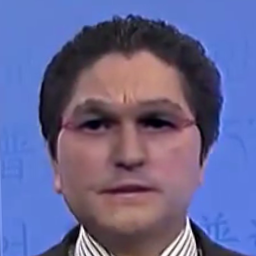

In [19]:
sample['image']

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")